## Parte 1: Eikonal del tutorial de PINNs

Supongamos que estamos analizando una región 2D recubierta por células del corazón. Algunas de ellas son marcapasos cardíacos, originando pulsos de propagación eléctrica hacia el resto del tejido. Usted dispone de múltiples electrodos en el dominio de observación, que le permiten determinar el tiempo en que una onda llega a cada uno de ellos.

Los tiempos de llegada normalizados pueden ser modelados mediante la ecuación Eikonal:

$$\sqrt{\nabla T \cdot \nabla T} = 1$$




In [18]:
import jax.numpy as np
from jax import random, grad, jit, vmap
import jax
from jax.scipy.optimize import minimize
import numpy as onp
from jax.example_libraries import optimizers
from functools import partial
from matplotlib import pyplot as plt
from pyDOE2 import lhs
key = random.PRNGKey(0)

In [19]:
def init_params(layers, key):

  Ws = [] # matriz de pesos
  bs = [] # vector de sesgos

  # inicialización de Glorot
  for i in range(len(layers) - 1):

    std_glorot = np.sqrt(2/(layers[i] + layers[i + 1]))
    key, subkey = random.split(key)
    Ws.append(random.normal(subkey, (layers[i], layers[i + 1]))*std_glorot)
    bs.append(np.zeros(layers[i + 1]))

  return [Ws, bs]

@jit
def forward_pass(H, params):

  Ws = params[0] # obtener pesos de la red
  bs = params[1] # obtener sesgos

  N_layers = len(Ws) # número total de capas (entrada + ocultas + salida)

  for i in range(N_layers - 1):

    H = np.matmul(H, Ws[i]) + bs[i] # pasar por aplicación lineal
    H = np.tanh(H) # activación tangente hiperbólica

  Y = np.matmul(H, Ws[-1]) + bs[-1] # pasar por capa de salida (sin función de activación)

  return Y

def create_grads():

  fp_wrapper = lambda x, params: forward_pass(x, params)[0] # output del paso forward
  du_dx = grad(fp_wrapper) # gradiente de jax

  du_dx_wrapper = lambda x, params: du_dx(x, params)[0] # output del gradiente
  du_dxx = grad(du_dx_wrapper)

  dU_dx = vmap(du_dx, in_axes = (0, None), out_axes=0) # vectorización de du_dx en eje 0
  dU_dxx = vmap(du_dxx, in_axes = (0, None), out_axes=0) # vectorización de du_dxx en eje 0

  return dU_dx, dU_dxx

grad_X, grad_XX = create_grads() # crear gradientes

@partial(jit, static_argnums=(0,)) # definir argumentos que serán tratados como estáticos

def step(loss, i, opt_state, X_batch, Y_batch, X_c, X_bd, X_bn):

    params = get_params(opt_state) # obtener parámetros
    g = grad(loss)(params, X_batch, Y_batch, X_c, X_bd, X_bn) # calcular gradiente de pérdida para el batch

    return opt_update(i, g, opt_state)

def train(loss, X, Y, X_c, opt_state, X_bd = None, X_bn = None, nIter = 10000):

    train_loss = []
    val_loss = []

    for it in range(nIter): # iterador de épocas

        opt_state = step(loss, it, opt_state, X, Y, X_c, X_bd, X_bn)

        if it % 100 == 0: # imprimir estados

            params = get_params(opt_state) # obtener parámetros
            train_loss_value = loss(params, X, Y, X_c, X_bd, X_bn) # ver pérdida en dicha época
            train_loss.append(train_loss_value) # agregar a lista

            to_print = "it %i, train loss = %e" % (it, train_loss_value)
            print(to_print)

    return get_params(opt_state), train_loss, val_loss

def train_bfgs(loss, params, x_train, u_train, x_c, x_bd = None, x_bn = None): # método bfgs

    def concat_params(params):

        flat_params, params_tree = jax.tree_util.tree_flatten(params)
        params_shape = [x.shape for x in flat_params]

        return np.concatenate([x.reshape(-1) for x in flat_params]), (params_tree, params_shape)

    def reconstruct_params(param_vector, params_shape):

        split_params = onp.split(param_vector, onp.cumsum([onp.prod(s) for s in params_shape[:-1]]))
        flat_params = [x.reshape(s) for x, s in zip(split_params, params_shape)]
        params = jax.tree_util.tree_unflatten(params_tree, flat_params)

        return params

    param_vector, (params_tree, params_shape) = concat_params(params)

    @jit
    def func(param_vector):
      params = reconstruct_params(param_vector, params_shape)

      return loss(params, x_train, u_train, x_c, x_bd, x_bn)

    results = minimize(func, param_vector, method = 'bfgs')

    print(results.fun)

    return reconstruct_params(results.x, params_shape)


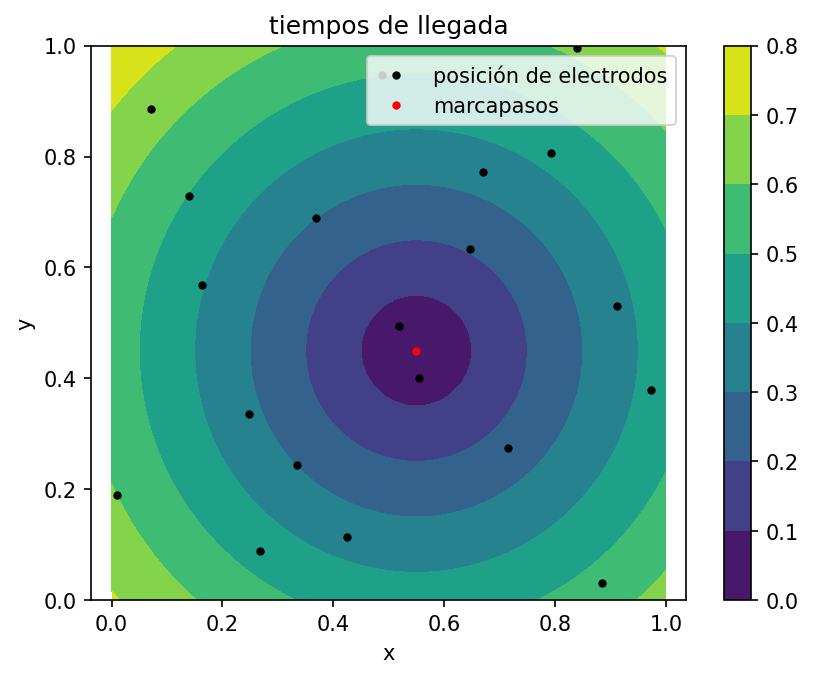

In [20]:
def F(x, c = np.array([0.55,0.45])):
  return np.linalg.norm(x - c)

xs = ys = np.linspace(0,1,50)
Xm, Ym = np.meshgrid(xs, ys)
x_star = np.c_[Xm.ravel(), Ym.ravel()] # concatenar arreglos

origin = np.array([0.55,0.45])
N_train = 20

x_train = lhs(2, N_train, random_state = 1234) # muestras aleatorias en el dominio
u_train = vmap(F, in_axes = (0, None))(x_train,origin)[:,None]

u_star = vmap(F, in_axes = (0, None))(x_star,origin)[:,None]

plt.figure(dpi = 150)
plt.contourf(Xm, Ym, u_star.reshape(Xm.shape))
plt.colorbar()

plt.plot(x_train[:,0],x_train[:,1], "k.", label = "posición de electrodos")
plt.plot(origin[0], origin[1], "r.", label = "marcapasos")

plt.xlabel("x")
plt.ylabel("y")
plt.title("tiempos de llegada")

plt.axis("equal")
plt.legend()

In [21]:
# redefinir función de entrenamiento para generar puntos de colocación aleatorios en cada iteración

def train(loss, X, Y, X_c_shape, opt_state, X_bd = None, X_bn = None, nIter = 10000):

    train_loss = []
    val_loss = []

    for it in range(nIter):

        X_c = lhs(X_c_shape[1], X_c_shape[0])
        opt_state = step(loss, it, opt_state, X, Y, X_c, X_bd, X_bn)

        if it % 100 == 0:

            params = get_params(opt_state)
            train_loss_value = loss(params, X, Y, X_c, X_bd, X_bn)
            train_loss.append(train_loss_value)

            to_print = "it %i, train loss = %e" % (it, train_loss_value)

            print(to_print)

    return get_params(opt_state), train_loss, val_loss


In [22]:
layers = [2, 100, 50, 20, 1]

params = init_params(layers, key)

opt_init, opt_update, get_params = optimizers.adam(1e-3)
opt_state = opt_init(params)

X_c_shape = (200,2) # number of collocations points

@jit
def loss(params, X, U, Xc, X_bd, X_bn):
  MSE_data = np.average((forward_pass(X, params) - U)**2)
  MSE_PDE = np.average((np.linalg.norm(grad_X(Xc,params),axis = 1)-1)**2)
  return  MSE_data + MSE_PDE
params, train_loss, val_loss = train(loss,x_train, u_train, X_c_shape, opt_state, nIter = 10000)

it 0, train loss = 8.334225e-01
it 100, train loss = 7.775875e-02
it 200, train loss = 7.647156e-02
it 300, train loss = 7.596646e-02
it 400, train loss = 7.529032e-02
it 500, train loss = 7.445321e-02
it 600, train loss = 7.343090e-02
it 700, train loss = 6.664310e-02
it 800, train loss = 6.300142e-02
it 900, train loss = 5.293852e-02
it 1000, train loss = 5.053095e-02
it 1100, train loss = 4.190269e-02
it 1200, train loss = 3.269960e-02
it 1300, train loss = 3.029583e-02
it 1400, train loss = 2.367508e-02
it 1500, train loss = 2.555507e-02
it 1600, train loss = 2.424233e-02
it 1700, train loss = 2.611890e-02
it 1800, train loss = 9.683686e-03
it 1900, train loss = 9.598336e-03
it 2000, train loss = 1.048874e-02
it 2100, train loss = 6.539087e-03
it 2200, train loss = 3.490646e-03
it 2300, train loss = 5.756803e-03
it 2400, train loss = 7.320372e-03
it 2500, train loss = 6.277934e-03
it 2600, train loss = 6.270289e-03
it 2700, train loss = 3.479164e-03
it 2800, train loss = 2.485470e-

error: 0.019414614886045456


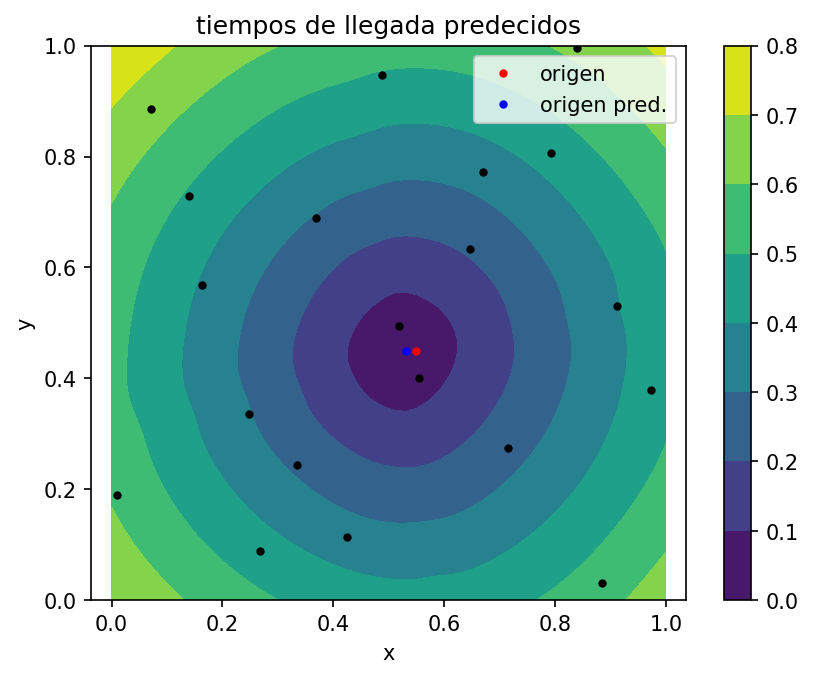

In [23]:
u_pred = forward_pass(x_star, params)
pred_origin = x_star[np.argmin(u_pred)] #la predicción será dd llegue en tpo 0

plt.figure(dpi=150)
plt.contourf(Xm, Ym, u_pred.reshape(Xm.shape))

plt.plot(x_train[:,0], x_train[:,1], "k.")
plt.plot(origin[0], origin[1], "r.", label = "origen")
plt.plot(pred_origin[0], pred_origin[1], "b.", label = "origen pred.")

plt.title('tiempos de llegada predichos')
plt.xlabel("x")
plt.ylabel("y")

plt.colorbar()
plt.axis('equal')
plt.legend()

print(f"error: {onp.linalg.norm(pred_origin - origin)}")

## Transformación del código a PyTorch

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import grad, Variable
import numpy as np
import matplotlib.pyplot as plt
from pyDOE2 import lhs

In [25]:
class NeuralNet(nn.Module):
    def __init__(self, layers):
        super(NeuralNet, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(len(layers) - 1):
            self.layers.append(nn.Linear(layers[i], layers[i + 1]))

    def forward(self, x):
        for i, layer in enumerate(self.layers[:-1]):
            x = torch.tanh(layer(x))
        return self.layers[-1](x)

def init_params(layers):
    model = NeuralNet(layers)
    # Inicialización Glorot/Xavier
    for layer in model.layers:
        torch.nn.init.xavier_normal_(layer.weight)
    return model

def train(model, optimizer, criterion, x_train, y_train, x_c, iterations=10000):
    model.train()
    for it in range(iterations):
        optimizer.zero_grad()
        u_pred = model(x_train)
        mse_data = criterion(u_g, fwd_sol)
        mse_pde = criterion(model(x_c), torch.tensor([[1.0]]))  # PDE constraint: e.g., grad(u) = 1
        loss = mse_data + mse_pde
        loss.backward()
        optimizer.step()

        if it % 100 == 0:
            print(f"Iteration {it}, Loss: {loss.item()}")

# Generación de muestras en el dominio de datos
def generate_data(num_samples):
    x_train = torch.rand(num_samples, 2)  # Uniform distribution
    y_train = torch.sqrt((x_train[:, 0] - 0.5)**2 + (x_train[:, 1] - 0.5)**2).unsqueeze(1)  # Distancia al centro (0.5, 0.5)
    return x_train, y_train


### Función de pérdida

In [26]:
def compute_pde_loss(model, x_c):
    x_c.requires_grad_(True)
    u_c = model(x_c)
    gradients = torch.autograd.grad(outputs=u_c, inputs=x_c, grad_outputs=torch.ones_like(u_c), create_graph=True)[0]
    mse_pde = torch.mean((torch.linalg.norm(gradients, dim=1) - 1)**2)  # Suponiendo la EDP: |grad(u)| = 1
    return mse_pde

### Función de entrenamiento

In [27]:
def train(model, optimizer, criterion, x_train, y_train, x_c, iterations=10000):
    model.train()
    for it in range(iterations):
        optimizer.zero_grad()
        u_pred = model(x_train)
        mse_data = criterion(u_pred, y_train)
        mse_pde = compute_pde_loss(model, x_c)

        loss = mse_data + mse_pde
        loss.backward()
        optimizer.step()

        if it % 100 == 0:
            print(f"Iteration {it}, Loss: {loss.item()}")


### Generación de datos
Datos aleatorios de la EDP para generar puntos de entrenamiento para la PINNs.

In [28]:
def generate_data():
    # Definir dominio
    xs = ys = np.linspace(0, 1, 50)
    Xm, Ym = np.meshgrid(xs, ys)
    x_star = np.hstack([Xm.ravel()[:, None], Ym.ravel()[:, None]])  # Dominio completo para predicción

    origin = np.array([0.55, 0.45])  # Origen de la propagación
    N_train = 20  # número de datos de entrenamiento

    # Generar puntos de entrenamiento usando LHS (Latin Hypercube Sampling)
    x_train = torch.tensor(lhs(2, N_train, criterion="center"), dtype=torch.float32)
    y_train = torch.sqrt((x_train[:, 0] - origin[0])**2 + (x_train[:, 1] - origin[1])**2).unsqueeze(1)

    return x_train, y_train, x_star, Xm, Ym, origin

x_train, y_train, x_star, Xm, Ym, origin = generate_data()


### Entrenamiento del modelo

Iteration 0, Loss: 0.7597571015357971
Iteration 100, Loss: 0.07390505820512772
Iteration 200, Loss: 0.07270161062479019
Iteration 300, Loss: 0.07152078300714493
Iteration 400, Loss: 0.07041866332292557
Iteration 500, Loss: 0.06651738286018372
Iteration 600, Loss: 0.05014033615589142
Iteration 700, Loss: 0.03738638758659363
Iteration 800, Loss: 0.020259210839867592
Iteration 900, Loss: 0.007025241851806641
Iteration 1000, Loss: 0.004217110108584166
Iteration 1100, Loss: 0.003099177498370409
Iteration 1200, Loss: 0.0024668981786817312
Iteration 1300, Loss: 0.002059179823845625
Iteration 1400, Loss: 0.0017895859200507402
Iteration 1500, Loss: 0.001620306633412838
Iteration 1600, Loss: 0.0014897154178470373
Iteration 1700, Loss: 0.001374189741909504
Iteration 1800, Loss: 0.0012703447137027979
Iteration 1900, Loss: 0.0011777557665482163
Iteration 2000, Loss: 0.0010935666505247355
Iteration 2100, Loss: 0.0010183772537857294
Iteration 2200, Loss: 0.0009736758074723184
Iteration 2300, Loss: 0.

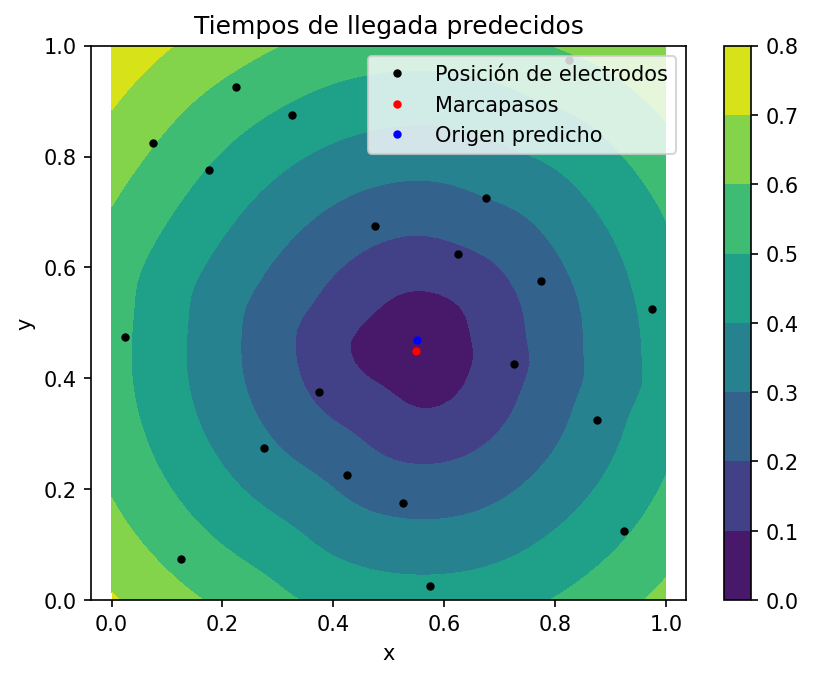

Error: 0.019414589378000405


In [29]:
def train(model, optimizer, criterion, x_train, y_train, x_c, iterations=10000):
    model.train()
    for it in range(iterations):
        optimizer.zero_grad()
        u_pred = model(x_train)
        mse_data = criterion(u_pred, y_train)
        mse_pde = compute_pde_loss(model, x_c)

        loss = mse_data + mse_pde
        loss.backward()
        optimizer.step()

        if it % 100 == 0:
            print(f"Iteration {it}, Loss: {loss.item()}")

# Datos de colocación para la EDP
x_c = torch.rand(200, 2, dtype=torch.float32)  # Simulando puntos de colocación

# Entrenar el modelo
model = init_params([2, 100, 50, 20, 1])
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = torch.nn.MSELoss()
train(model, optimizer, criterion, x_train, y_train, x_c)

u_pred = model(torch.tensor(x_star, dtype=torch.float32)).detach().numpy().reshape(Xm.shape)
pred_origin = x_star[np.argmin(u_pred)]

plt.figure(dpi=150)
plt.contourf(Xm, Ym, u_pred)
plt.plot(x_train[:, 0], x_train[:, 1], "k.", label="Posición de electrodos")
plt.plot(origin[0], origin[1], "r.", label="Marcapasos")
plt.plot(pred_origin[0], pred_origin[1], "b.", label="Origen predicho")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Tiempos de llegada predichos")
plt.colorbar()
plt.legend()
plt.axis('equal')
plt.show()
print(f"Error: {np.linalg.norm(pred_origin - origin)}")


## Problema inverso con tensor de conductividad $D$
A continuación se busca realizar lo mismo pero con un tensor de conductividad $D(x)$
$$
\sqrt{D(x) \nabla T(x) \cdot \nabla T(x)} = 1
$$
El tensor de condutividad actúa como la dirección del flujo, que se interpreta como flujo eléctrico. El caso visto anteriormente corresponde a una conductividad uniforme.

El objetivo de esta parte es, a partir del mapeo de tiempos de llegada, encontrar el tensor de conductividad.

Para este caso consideramos $$D(x) = v_t^2(x)I+(v_\ell^2(x)-v_t^2(x))\ell(x)\otimes \ell(x)$$, donde $\ell(x)$ es la dirección local de la fibra, definida como $\ell(x) = a(x)^2\vec{e_1}+\sqrt{1-a(x)^2}\vec{e_2}$ con $a(x) \in [-1,1]$

## Definición del modelo

In [114]:
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.spatial import cKDTree
import numpy as np

class MultiAnisoEikonalPINN_2D(nn.Module):
    def __init__(self, X, triangs, parallel, X_e, T_e, layers, CVlayers, Tmax,
                 CVmax=1.0, lambda_df=1., lambda_pde=1e-4,
                 lambda_tve=1e-2, lambda_tva=1e-9):
        super().__init__()
        
        self.X = torch.tensor(X, dtype=torch.float32)
        self.T_e = torch.tensor(T_e, dtype=torch.float32)
        self.X_e = torch.tensor(X_e, dtype=torch.float32)
        self.parallel = parallel
        self.Tmax = torch.tensor(Tmax, dtype=torch.float32)
        self.CVmax = CVmax
        self.lambda_df = lambda_df
        self.lambda_pde = lambda_pde
        self.lambda_tve = lambda_tve
        self.lambda_tva = lambda_tva
        self.weights = nn.ModuleList()
        self.biases = nn.ModuleList()
        self.CVweights = nn.ModuleList()
        self.CVbiases = nn.ModuleList()

        # Setup networks
        for _ in range(parallel):
            net = self.initialize_nn(layers)
            self.weights.append(net)
        
        self.CVnetwork = self.initialize_nn(CVlayers)

        # Optimizer
        self.optimizer = optim.Adam(self.parameters(), lr=1e-3)

    def initialize_nn(self, layers):
        model_layers = []
        for i in range(len(layers)-1):
            model_layers.append(nn.Linear(layers[i], layers[i+1]))
            model_layers.append(nn.ReLU())
        model_layers.pop()  # Remove the last ReLU
        return nn.Sequential(*model_layers)


In [115]:
def forward(self, X, P_p):
    T_pred = []
    for net in self.weights:
        T_pred.append(net(X))
    CV_pred = self.CVnetwork(X)
    
    # You would need to add the logic to combine these outputs in a meaningful way
    # depending on the model's specifics.

    return T_pred, CV_pred


In [116]:
def compute_loss(self, T_pred, CV_pred, T_actual, CV_actual):
    pde_loss = self.lambda_pde * torch.mean((T_pred - T_actual) ** 2)
    tv_loss = self.lambda_tve * torch.mean(CV_pred ** 2)  # Example, adjust based on actual usage
    data_fidelity_loss = self.lambda_df * torch.mean((CV_pred - CV_actual) ** 2)
    return pde_loss + tv_loss + data_fidelity_loss


In [117]:
def train_model(self, epochs):
    for epoch in range(epochs):
        self.train()  # Set the model to training mode
        T_pred, CV_pred = self.forward(self.X, None)  # Assuming P_p is processed within forward
        loss = self.compute_loss(T_pred, CV_pred, self.T_e, self.X_e)  # Simplified
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        print(f'Epoch {epoch+1}, Loss: {loss.item()}')


In [124]:
import torch
import numpy as np

def generate_D(x, y):
    D = torch.zeros(x.size(0), 2, 2)
    condition = x + y < 0
    D[condition] = torch.tensor([[1.0, 0.0], [0.0, 0.5]])
    D[~condition] = torch.tensor([[0.5, 0.0], [0.0, 1.0]])
    return D

# Create a grid of points in the domain [-1, 1] x [-1, 1]
x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)
X, Y = np.meshgrid(x, y)
X = torch.tensor(X.reshape(-1), dtype=torch.float32)
Y = torch.tensor(Y.reshape(-1), dtype=torch.float32)

# Generate D(x, y) for each point in the grid
D_xy = generate_D(X, Y)


In [125]:
class EikonalPINN(nn.Module):
    def __init__(self, input_dim, hidden_layers, output_dim):
        super(EikonalPINN, self).__init__()
        layers = [nn.Linear(input_dim, hidden_layers[0]), nn.Tanh()]
        for i in range(1, len(hidden_layers)):
            layers += [nn.Linear(hidden_layers[i - 1], hidden_layers[i]), nn.Tanh()]
        layers.append(nn.Linear(hidden_layers[-1], output_dim))
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)


In [126]:
# def eikonal_loss(T, D, x):
#     T_grad = torch.autograd.grad(T.sum(), x, create_graph=True)[0]
#     D_T_grad = torch.bmm(D, T_grad.unsqueeze(2)).squeeze(2)
#     norm_sq = (T_grad * D_T_grad).sum(1)
#     return torch.mean((torch.sqrt(norm_sq) - 1) ** 2)

def eikonal_loss(T, D, x):
    # Ensure gradients are retained for the computation
    T_grad = torch.autograd.grad(T, x, grad_outputs=torch.ones_like(T), create_graph=True)[0]
    # Correctly compute the product of the tensor D with the gradients of T
    # D has shape [batch_size, 2, 2], T_grad has shape [batch_size, 2]
    # We need to perform batch matrix-vector multiplication
    D_T_grad = torch.bmm(D, T_grad.unsqueeze(-1)).squeeze(-1)
    norm_sq = (T_grad * D_T_grad).sum(1)
    return torch.mean((torch.sqrt(norm_sq) - 1) ** 2)


# Example usage in a training loop
# model = EikonalPINN(input_dim=2, hidden_layers=[50, 50, 50], output_dim=1)
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# X_train = torch.stack((X, Y), dim=1)  # Training data
# for epoch in range(1000):
#     optimizer.zero_grad()
#     T_pred = model(X_train).squeeze()
#     loss = eikonal_loss(T_pred, D_xy, X_train)
#     loss.backward()
#     optimizer.step()

#     if epoch % 100 == 0:
#         print(f"Epoch {epoch}, Loss: {loss.item()}")

model = EikonalPINN(input_dim=2, hidden_layers=[50, 50, 50], output_dim=1)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Ensure X and Y are tensors with requires_grad enabled
X_train = torch.stack((X, Y), dim=1)
X_train.requires_grad_(True)

for epoch in range(1000):
    optimizer.zero_grad()
    T_pred = model(X_train).squeeze(1)  # Ensure T_pred is appropriately sized
    loss = eikonal_loss(T_pred, D_xy, X_train)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")



Epoch 0, Loss: 0.9360976815223694
Epoch 100, Loss: 0.012103332206606865
Epoch 200, Loss: 0.002803583163768053
Epoch 300, Loss: 0.00028126672259531915
Epoch 400, Loss: 0.00015420322597492486
Epoch 500, Loss: 0.00011632604582700878
Epoch 600, Loss: 9.042904275702313e-05
Epoch 700, Loss: 7.085762626957148e-05
Epoch 800, Loss: 5.6367374781984836e-05
Epoch 900, Loss: 4.5703956857323647e-05


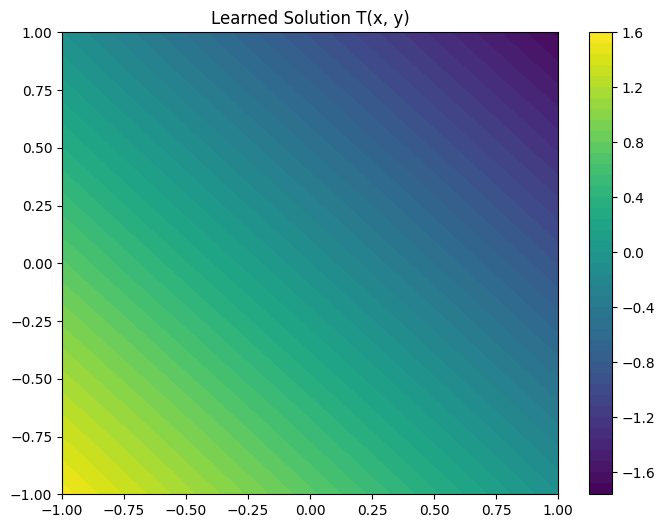

In [127]:
import matplotlib.pyplot as plt

T_grid = T_pred.detach().numpy().reshape(100, 100)
plt.figure(figsize=(8, 6))
plt.contourf(X.reshape(100, 100), Y.reshape(100, 100), T_grid, levels=50)
plt.colorbar()
plt.title("Learned Solution T(x, y)")
plt.show()

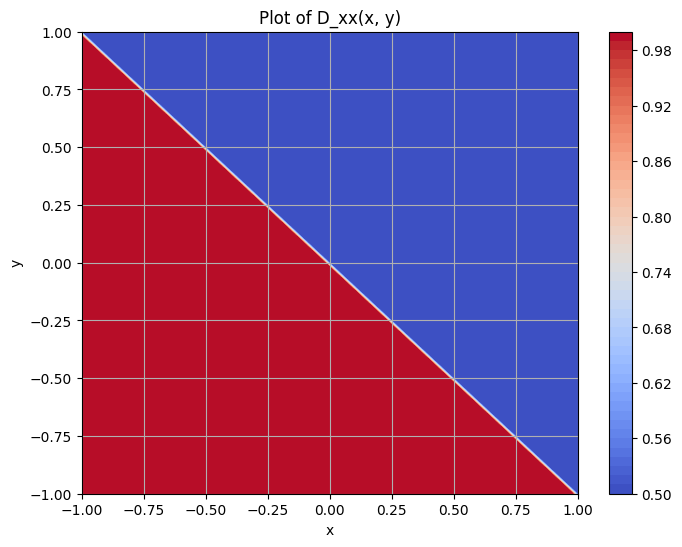

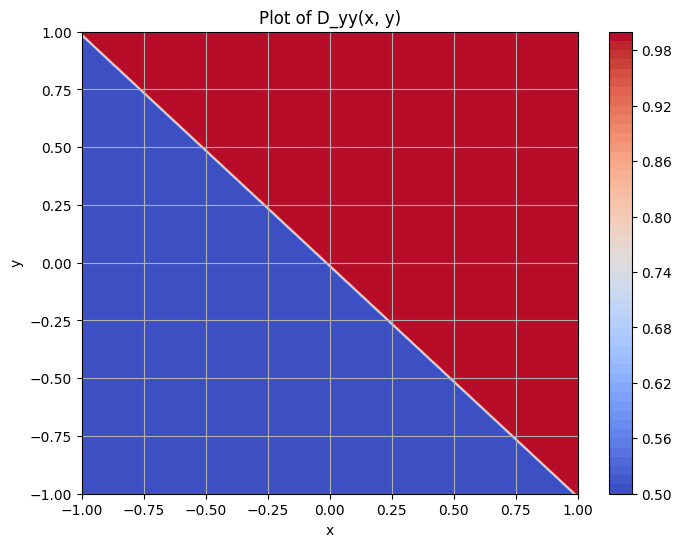

In [122]:
import numpy as np
import matplotlib.pyplot as plt
import torch

def generate_D(x, y):
    # Returns a tensor for each x, y pair
    D = torch.zeros(len(x), 2, 2)
    condition = x + y < 0
    D[condition] = torch.tensor([[1.0, 0.0], [0.0, 0.5]])
    D[~condition] = torch.tensor([[0.5, 0.0], [0.0, 1.0]])
    return D

# Create a grid of points in the domain [-1, 1] x [-1, 1]
x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)
X, Y = np.meshgrid(x, y)
X_flat = X.flatten()
Y_flat = Y.flatten()

# Generate D(x, y) for each point in the grid
D_xy = generate_D(torch.tensor(X_flat), torch.tensor(Y_flat))

# Extract the D_xx component for visualization
D_xx = D_xy[:, 0, 0].view(100, 100).numpy()  # Ensure correct extraction and reshaping

# Plotting the D_xx component
plt.figure(figsize=(8, 6))
contour = plt.contourf(X, Y, D_xx, levels=50, cmap='coolwarm')
plt.colorbar(contour)
plt.title('Plot of D_xx(x, y)')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.show()

D_yy = D_xy[:, 1, 1].view(100, 100).numpy()  # Ensure correct extraction and reshaping

# Plotting the D_yy component
plt.figure(figsize=(8, 6))
contour = plt.contourf(X, Y, D_yy, levels=50, cmap='coolwarm')
plt.colorbar(contour)
plt.title('Plot of D_yy(x, y)')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.show()



In [100]:
import numpy as np
import matplotlib.pyplot as plt
import torch

def create_D_tensor(x, y):
    D = torch.zeros(len(x), 2, 2)
    condition = x + y < 0
    D[condition] = torch.tensor([[1.0, 0.0], [0.0, 0.5]])
    D[~condition] = torch.tensor([[0.5, 0.0], [0.0, 1.0]])
    return D[:, 0, 0], D[:, 1, 1]  # Return Dxx and Dyy

# Domain setup
x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)
X, Y = np.meshgrid(x, y)
X_flat = X.flatten()
Y_flat = Y.flatten()
Dxx, Dyy = create_D_tensor(torch.tensor(X_flat), torch.tensor(Y_flat))
Dxx = Dxx.view(100, 100).numpy()
Dyy = Dyy.view(100, 100).numpy()


In [4]:
# !git clone https://github.com/thomgrand/fim-python
# !pip install -e .[gpu]

fatal: destination path '.' already exists and is not an empty directory.


Obtaining file:///C:/Users/spuky/AppData/Local/Programs/Microsoft%20VS%20Code


ERROR: file:///C:/Users/spuky/AppData/Local/Programs/Microsoft%20VS%20Code does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.


In [3]:
import time
import numpy as np
from pyDOE import lhs
from fimpy.solver import FIMPY
from scipy.spatial import cKDTree
from collections import defaultdict
from mesh_tools import cellToPointData, pointToCellData
from math_tools import eigenDecompProd, matMulProdSum, metricNormMatrix
from tqdm.auto import trange

class SyntheticDataGenerator2D:
  """
  Create a set of cardiac activation maps on 2D grid mesh

  Parameters:
  grid_points: int number of points on the side of the square grid (total points = grid_points x grid_points)
  sample_points: int total number of points to sample across all maps (each map has sample_points/maps_number)
  maps_number: int number of activation maps desired
  """
  def __init__(self, grid_points=35, sample_points=245, maps_number=2, noise=0.) -> None:
    # Grid points must be more than sample points
    assert grid_points**2 > sample_points

    # Create mesh points         
    x = y = np.linspace(-1,1,grid_points)[:,None]
    X_m, Y_m = np.meshgrid(x,y)
    self.X_m, self.Y_m = X_m, Y_m
    X = X_m.flatten()[:,None]
    Y = Y_m.flatten()[:,None]
    Z = np.zeros_like(X)
    self.points = np.concatenate([X,Y,Z],axis=-1)

    # Create conduction velocity values
    cv = self.get_simulated_CV(X,Y)
    self.cv = cv
    eigenvectors = cv[0:4]
    eigenvectors.reshape(X_m.shape[0],X_m.shape[1],4)

    # Create mesh triangles
    triangles_list = []
    for i in np.arange(len(self.points)-grid_points):
      if i%grid_points!=grid_points-1:
        triangles_list.append([3,i,i+1,i+grid_points])
        triangles_list.append([3,i+1,i+grid_points,i+grid_points+1])
    triangles_array = np.array(triangles_list)
    self.triangles = triangles_array[:,1:]

    ## Create D tensor
    zed = np.zeros_like(cv[4])
    normal_cv = np.ones_like(cv[4]) * 1.e-3
    D_init = np.stack([cv[4],cv[6],zed,cv[6],cv[5],zed,zed,zed,normal_cv], axis=-1).reshape([-1,3,3])
    self.fiber_vecs = np.linalg.eigh(D_init)[1]
    D_init_cells = pointToCellData(self.points, self.triangles, D_init)

    # Select measurement points and initiation sites
    measurement_mask = np.zeros(self.points.shape[0], dtype=bool)
    kdtree_X = cKDTree(self.points)
    X_t = lhs(2, sample_points, 'c')*2-1
    X_train = np.concatenate([X_t,Z[:X_t.shape[0]]],axis=-1)
    sample_indices = kdtree_X.query(X_train)[1]
    sample_indices = self.remove_duplicates(sample_indices)
    sample_indices = sample_indices[:len(sample_indices)//maps_number*maps_number] #This might throw off exact number of sample points
    measurement_mask[sample_indices] = True
    print("Real number of sample points taken: ", len(sample_indices))
    initiation_sites = lhs(2, 5, 'm')*2-1
    initiation_sites = np.concatenate([initiation_sites,Z[:initiation_sites.shape[0]]],axis=-1)
    initiation_sites = kdtree_X.query(initiation_sites)[1]

    # Get activation times from initiation sites and cv with FIM method
    split_sample_points = np.array_split(sample_indices, maps_number)
    fim = FIMPY.create_fim_solver(self.points, self.triangles, D_init_cells, device='cpu', use_active_list=False)
    X_dirichlet = []
    phi_dirichlet = []
    phi_max = []
    phis = []
    x0_vals = np.zeros(maps_number)
    for i, idx in enumerate(split_sample_points):
      phi = fim.comp_fim(initiation_sites[i], x0_vals[i])
      phi += noise * np.random.randn(phi.shape[0])
      phis.append(phi)
      m_mask = np.zeros(self.points.shape[0], dtype=bool)
      m_mask[idx] = True
      X_dirichlet.append(self.points[m_mask])
      phi_dirichlet.append(phi[m_mask])
      phi_max.append(phi_dirichlet[i].max())
      phi_dirichlet[i] = phi_dirichlet[i]/phi_max[i]
    X_dirichlet = np.transpose(np.stack(X_dirichlet, axis=0),[1,2,0])
    phi_dirichlet = np.transpose(np.stack(phi_dirichlet, axis=0))
    phis = np.transpose(np.stack(phis, axis=0))

    self.phi = phis
    self.phi_max = phi_max
    self.T_e = phi_dirichlet
    self.X_e = X_dirichlet

  def get_simulated_CV(self, X, Y):
    """
    Returns values of 2d FiberNet paper simulated conduction velocities in different formats
    The values are:
    [eigenvector1_x_val, eigenvector1_y_val, eigenvector2_x_val, eigenvector1_y_val,
    matrix_format_val_00, matrix_format_val_11, matrix_format_val_10]
    """
    mask = np.less_equal(np.sqrt((X+1)**2 + 2*(Y+1)**2),np.sqrt(2*(X-1)**2 + (Y-1)**2))
    d1 = mask*1.0 + ~mask*0.5
    d2 = mask*0.5 + ~mask*1.0
    d12 = mask*0.0 + ~mask*0.0
    c = (d1+d2)/2
    r = np.sqrt((d1-c)**2+d12**2)
    a = np.arctan2(d12,(d1-c))/2
    e1 = c+r
    e2 = c-r
    e1x = e1*np.cos(a)
    e1y = e1*np.sin(a)
    e2x = -e2*np.sin(a)
    e2y = e2*np.cos(a)
    return np.array([e1x, e1y, e2x, e2y, d1, d2, d12])
  
  def remove_duplicates(self, old_list):
    unwanted = []
    tally = defaultdict(list)
    for i,item in enumerate(old_list):
        tally[item].append(i)
    duples = ((key,locs) for key,locs in tally.items() 
                            if len(locs)>1)
    for duplicates in sorted(duples):
        dupe = duplicates[1][1:]
        for name in dupe: 
          unwanted.append(name)
    new_list = [i for j, i in enumerate(old_list) if j not in unwanted]
    return new_list

  def get_geometry(self):
    return self.points, self.triangles, self.X_m, self.Y_m

  def get_activation_maps(self):
    return self.phi, self.X_e, self.T_e, self.phi_max

  def get_fiber_vectors(self):
    return self.fiber_vecs, self.cv

def D_printer(D):
    d1 = D[:,0,0]
    d2 = D[:,1,1]
    d12 = D[:,0,1]
    c = (d1+d2)/2
    r = np.sqrt((d1-c)**2+d12**2)
    a = np.arctan2(d12,(d1-c))/2
    e1 = c+r
    e2 = c-r
    e1x = e1*np.cos(a)
    e1y = e1*np.sin(a)
    e2x = -e2*np.sin(a)
    e2y = e2*np.cos(a)
    return np.array([e1x, e1y, e2x, e2y])

ModuleNotFoundError: No module named 'fimpy.solver'